In [2]:
import findspark
import streamlit
findspark.init()

In [69]:
import pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder \
            .config("spark.driver.memory", "20g") \
            .getOrCreate()

24/10/18 10:20:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Loading Data

In [4]:
df = spark.read.csv("MovieReviewsKaggle_Clean.csv", inferSchema=True, header=True)
df.show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|I grew up (b. 196...|    0|
|When I put this m...|    0|
|Why do people who...|    0|
|Even though I hav...|    0|
|Im a die hard Dad...|    1|
|A terrible movie ...|    0|
|Finally watched t...|    1|
|I caught this fil...|    0|
|It may be the rem...|    1|
|My Super Ex Girlf...|    1|
|I can't believe p...|    1|
|If you haven't se...|    0|
|I have always bee...|    1|
|Greg Davis and Br...|    0|
|A half-hearted at...|    0|
|If you want a fun...|    1|
|I really wanted t...|    1|
|The main problem ...|    0|
|The folks at Disn...|    0|
|A friend told me ...|    0|
+--------------------+-----+
only showing top 20 rows



## Trasfomers Review

Transformers are simply classes, which take an input dataframe and column name, and return a dataframe with an added column where the input column has been “transformed”

**Bucketizer** is an example of a transform, it takes in a column of
continuous values numeric values and outputs a column of values sorted
into buckets with the bucket size being passed as a parameter

In [5]:
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -0.5, 0.0, 0.5, float("inf")]

data = [(-999.9,), (-0.5,), (-0.3,), (0.0,), (0.2,), (999.9,)]
dataFrame = spark.createDataFrame(data, ["features"])

bucketizer = Bucketizer(splits=splits, inputCol="features", outputCol="bucketedFeatures")

# Transform original data into its bucket index.
bucketedData = bucketizer.transform(dataFrame)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits()) - 1))
bucketedData.show()

Bucketizer output with 4 buckets


+--------+----------------+
|features|bucketedFeatures|
+--------+----------------+
|  -999.9|             0.0|
|    -0.5|             1.0|
|    -0.3|             1.0|
|     0.0|             2.0|
|     0.2|             2.0|
|   999.9|             3.0|
+--------+----------------+



#### Estimator vs Transformer
- We call `fit()` on the estimator to return the model.
- We then call `transform()` on the model.

### StringIndexer
- This is a transformer which converts categorical features into numerical ones
- i.e encodings

In [6]:
from pyspark.ml.feature import StringIndexer

broken_df = spark.read.csv("BrokenDataset.csv", inferSchema=True, header=True)

indexer = StringIndexer(inputCol="lunch", outputCol="lunchIndex")
indexed = indexer.fit(broken_df).transform(broken_df)
indexed.select("lunch", "lunchIndex").show(10)

+------------+----------+
|       lunch|lunchIndex|
+------------+----------+
|    standard|       0.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|    standard|       0.0|
|    standard|       0.0|
|    standard|       0.0|
|free/reduced|       1.0|
|free/reduced|       1.0|
|free/reduced|       1.0|
+------------+----------+
only showing top 10 rows



## Tokeniser

In [7]:
from pyspark.ml.feature import Tokenizer

tokeniser = Tokenizer(inputCol="text", outputCol="text_tokens")
tokenised = tokeniser.transform(df)

tokenised.show(5)


+--------------------+-----+--------------------+
|                text|label|         text_tokens|
+--------------------+-----+--------------------+
|I grew up (b. 196...|    0|[i, grew, up, (b....|
|When I put this m...|    0|[when, i, put, th...|
|Why do people who...|    0|[why, do, people,...|
|Even though I hav...|    0|[even, though, i,...|
|Im a die hard Dad...|    1|[im, a, die, hard...|
+--------------------+-----+--------------------+
only showing top 5 rows



#### Removing Stop Words

In [8]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="text_tokens", outputCol="text_filtered_tokens")
cleaned = remover.transform(tokenised)
cleaned.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### N-Gram Model

In [9]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="text_filtered_tokens", outputCol="ngrams")
ngramDataFrame = ngram.transform(cleaned)
ngramDataFrame.select("ngrams").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## OneHotEncoder

In [10]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol='lunchIndex', outputCol="oneHot")
model = encoder.fit(indexed)
encoded = model.transform(indexed)
encoded.select("oneHot").show(10)

+-------------+
|       oneHot|
+-------------+
|(1,[0],[1.0])|
|(1,[0],[1.0])|
|(1,[0],[1.0])|
|    (1,[],[])|
|(1,[0],[1.0])|
|(1,[0],[1.0])|
|(1,[0],[1.0])|
|    (1,[],[])|
|    (1,[],[])|
|    (1,[],[])|
+-------------+
only showing top 10 rows



## Normaliser

In [11]:
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors

normaliser = Normalizer(inputCol="oneHot", outputCol="normFeatures", p=1.0)
l1norm = normaliser.transform(encoded)
l1norm.show()


+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|lunchIndex|       oneHot| normFeatures|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|       0.0|(1,[0],[1.0])|(1,[0],[1.0])|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|       0.0|(1,[0],[1.0])|(1,[0],[1.0])|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|       0.0|(1,[0],[1.0])|(1,[0],[1.0])

In [12]:
# Normalize each Vector using $L^\infty$ norm.
lInfNormData = normaliser.transform(encoded, {normaliser.p: float("inf")})
print("Normalized using L^inf norm")
lInfNormData.show()

Normalized using L^inf norm
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+----------+-------------+-------------+
|gender|race/ethnicity|parental level of education|       lunch|test preparation course|math score|reading score|writing score|lunchIndex|       oneHot| normFeatures|
+------+--------------+---------------------------+------------+-----------------------+----------+-------------+-------------+----------+-------------+-------------+
|female|       group B|          bachelor's degree|    standard|                   none|        72|           72|           74|       0.0|(1,[0],[1.0])|(1,[0],[1.0])|
|female|       group C|               some college|    standard|              completed|        69|           90|           88|       0.0|(1,[0],[1.0])|(1,[0],[1.0])|
|female|       group B|            master's degree|    standard|                   none|        90|           95|           93|       0.0

# Sentiment Analysis Pipeline

In [13]:
df.show(10, truncate=False)
df.printSchema()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [72]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import col 
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib as plt 
# data transformers 
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, IDF
# ml model (estimator)
from pyspark.ml.classification import LogisticRegression

schema = StructType(
    [
        StructField("text", StringType(), True),
        StructField("label", IntegerType(), True)
     ])

# split the data
train, test = df.randomSplit([0.7, 0.3])

# pipeline
from pyspark.ml import Pipeline

tokeniser = Tokenizer(inputCol="text", outputCol="words")
stopWords = StopWordsRemover(inputCol=tokeniser.getOutputCol(), outputCol="useful_words")
hasher = HashingTF(inputCol=stopWords.getOutputCol(), outputCol="hashed_words")
idf = IDF(inputCol=hasher.getOutputCol(), outputCol="features")
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100, regParam=0.01)

pipeline_stages = [tokeniser, stopWords, hasher, idf, lr]
pipeline = Pipeline(stages=pipeline_stages)

model = pipeline.fit(train)

# testing 

pred = model.transform(test)

pred.drop("words", "useful_words", "features", "rawPrediction", "probability")
predicted = pred.withColumn("prediction",pred["prediction"].cast(IntegerType()))

predicted.select(predicted.text, predicted.prediction, predicted.label).sample(0.01).show(n=20, truncate=80)

accuracy = predicted.filter(predicted.label == predicted.prediction).count() / float(test.count())
accuracy


24/10/18 10:24:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/10/18 10:24:32 WARN DAGScheduler: Broadcasting larg

+--------------------------------------------------------------------------------+----------+-----+
|                                                                            text|prediction|label|
+--------------------------------------------------------------------------------+----------+-----+
|"Ninja III" is not quite as bad as "Enter The Ninja", the first part of this ...|         0|    0|
|Franco proves, once again, that he is the prince of surreal & erotic cinema. ...|         1|    1|
|I know that Chill Wills usually played lovable old sorts in Westerns. But his...|         1|    1|
|The basic formula for the original series was; take someone, get the audience...|         0|    0|
|The comparison to Sleuth, the earlier stage-play-turned-film, is obvious and ...|         1|    1|
|This film can be judged from three viewpoints: as history, as a profile of Am...|         0|    0|
|This is definitely the worst bigfoot movie I've ever seen and quite possibly ...|         0|    0|


24/10/18 10:24:41 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


0.8561352821210061

24/10/18 10:24:55 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:24:56 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:24:57 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:24:58 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


<Axes: >

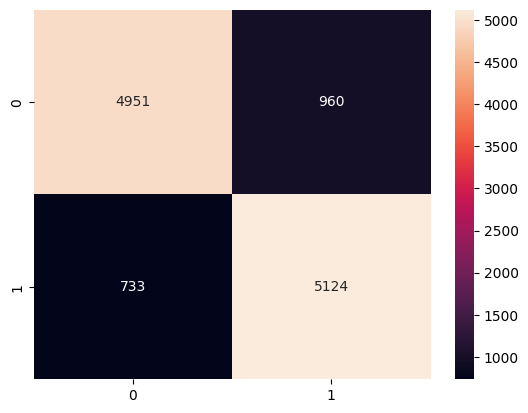

In [73]:
# total rows 
totaltestrows = predicted.count()
positiveCorrect = predicted.where((col("prediction") == "1") & (col("label") == 1)).count()
negativeCorrect = predicted.where((col("prediction") == "0") & (col("label") == 0)).count()
positiveinCorrect = predicted.where((col("prediction") == "1") & (col("label") == 0)).count()
negativeinCorrect = predicted.where((col("prediction") == "0") & (col("label") == 1)).count()

totalcorrect = positiveCorrect + negativeCorrect
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
values = [negativeCorrect, positiveinCorrect, negativeinCorrect, positiveCorrect]

labels = np.asarray(labels).reshape(2,2)
values = np.asarray(values).reshape(2,2)

confusion = ([[negativeCorrect, positiveinCorrect], [negativeinCorrect, positiveCorrect]])
sns.heatmap(confusion, annot=True, fmt="g")

In [74]:
data = [("I hardly could have given a poorer performance, I'd say it was shockingly bad", 0)]
ndf = spark.createDataFrame(data=data, schema=schema)
pred = model.transform(ndf)
pred.show(truncate=10)

data = [("I think this movie rocks, its almost perfect in its achievement its the best movie ever!",1)]
ndf = spark.createDataFrame(data=data, schema=schema)
pred = model.transform(ndf)
pred.show(truncate=10)

24/10/18 10:25:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:25:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:25:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+
|      text|label|     words|useful_words|hashed_words|  features|rawPrediction|probability|prediction|
+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+
|I hardl...|    0|[i, har...|  [hardly...|  (262144...|(262144...|   [0.5408...| [0.6320...|       0.0|
+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+



24/10/18 10:25:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
24/10/18 10:25:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+
|      text|label|     words|useful_words|hashed_words|  features|rawPrediction|probability|prediction|
+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+
|I think...|    1|[i, thi...|  [think,...|  (262144...|(262144...|   [-0.922...| [0.2844...|       1.0|
+----------+-----+----------+------------+------------+----------+-------------+-----------+----------+



24/10/18 10:25:04 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


# Improving the model

## adding more data

In [67]:
more_data = spark.read.csv("combined.csv", inferSchema=True, header=True)

more_data = more_data.selectExpr("text as text", "label as label_str")
more_data = more_data.withColumn("label", more_data['label_str'].cast(IntegerType()))
more_data = more_data.drop("label_str")

more_data = more_data.na.drop("any")